## Quantum Cryptography & Security: lab report 01 - QRNG

## Author: David Polzoni, ID: 2082157

## Mounting Google Drive, dataset & imports

In [ ]:
# This script would mount the drive onto the Colab Notebook
# If there is a drive mounted, the notebook would return:
# "Mounted at /content/drive" or "Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True)"
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to experimental data
experimental_data_path = "/content/drive/My Drive/QCS-Lab-01-QRNG-Data/"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import warnings
from math import e
from google.colab import files as gc_files
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.io import loadmat

In [ ]:
# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Experimental data: coincidences & gaussian fits

In [ ]:
def df_from_mat(path):
    """
    Load the data from the .mat file and return a dataframe (time is expressed in seconds)
    """
    print('Loading data: '+str(path))
    mat_file = loadmat(path)
    time = mat_file['timetag'] * 1e-12 # rescale in ps
    min_time = np.min(time)
    new_time = np.array([t - min_time for t in time])
    channel = mat_file['channel']
    df = pd.DataFrame({'time': new_time.flatten(), 'channel': channel.flatten()})
    return df

def find_coincidences(df):
    """
    Read the dataset and keep only the events which have a coincidence
    between channel 1 with channel 2 or channel 3.
    It's possible to decide the coincidence window, a suggested value is around 4 ns.
    """
    print('Finding coincidences...')
    ch_2 = df[df['channel'] != 3]
    ch_3 = df[df['channel'] != 2]
    ch_2 = ch_2.diff()
    ch_3 = ch_3.diff()
    ch_2['channel'] = 2
    ch_3['channel'] = 3
    ch_2 = ch_2[ch_2['channel'] != 0]
    ch_3 = ch_3[ch_3['channel'] != 0]
    coincidences = ch_2.append(ch_3)
    return coincidences

def coincidences_to_txt(filename_path):
    """
    Read the data from the .mat file given as argument and find the coincidences.
    Coincidences are saved in a .txt file in the coincidences folder.
    """
    df = df_from_mat(filename_path)
    if not os.path.exists('/content/coincidences'):
      os.mkdir('/content/coincidences')
    coincidences = find_coincidences(df)
    coincidences.to_csv('/content/coincidences/' + os.path.basename(filename_path)[:-4] + '_coincidences.txt', index=False)

In [ ]:
coincidences_to_txt(experimental_data_path + 'd_da.mat')
coincidences_to_txt(experimental_data_path + 'd_hv.mat')
coincidences_to_txt(experimental_data_path + 'l_da.mat')
coincidences_to_txt(experimental_data_path + 'l_hv.mat')
coincidences_to_txt(experimental_data_path + 'l_lr.mat')
coincidences_to_txt(experimental_data_path + 'mixed_da.mat')
coincidences_to_txt(experimental_data_path + 'mixed_hv.mat')

Loading data: /content/drive/My Drive/QCS-Lab-01-QRNG-Data/d_da.mat
Finding coincidences...
Loading data: /content/drive/My Drive/QCS-Lab-01-QRNG-Data/d_hv.mat
Finding coincidences...
Loading data: /content/drive/My Drive/QCS-Lab-01-QRNG-Data/l_da.mat
Finding coincidences...
Loading data: /content/drive/My Drive/QCS-Lab-01-QRNG-Data/l_hv.mat
Finding coincidences...
Loading data: /content/drive/My Drive/QCS-Lab-01-QRNG-Data/l_lr.mat
Finding coincidences...
Loading data: /content/drive/My Drive/QCS-Lab-01-QRNG-Data/mixed_da.mat
Finding coincidences...
Loading data: /content/drive/My Drive/QCS-Lab-01-QRNG-Data/mixed_hv.mat
Finding coincidences...


In [ ]:
def clean_df(data, cut=1e-8, window=4e-9):
    # Data cleaning of independent events
    df = data[data['time'] < cut]
    # Gaussian fit
    gaussian_ch2 = stats.norm.fit(df[df['channel'] == 2].time)
    gaussian_ch3 = stats.norm.fit(df[df['channel'] == 3].time)
    print('Fitting...')
    print('Channel 2 - mean: {}, std: {}'.format(gaussian_ch2[0], gaussian_ch2[1]))
    print('Channel 3 - mean: {}, std: {}'.format(gaussian_ch3[0], gaussian_ch3[1]))
    if gaussian_ch2[0] < gaussian_ch3[0]:
        ll_cut = gaussian_ch2[0] - window
        lr_cut = gaussian_ch2[0] + window
        rr_cut = gaussian_ch3[0] + window
        rl_cut = gaussian_ch3[0] - window
    else:
        ll_cut = gaussian_ch3[0] - window
        lr_cut = gaussian_ch3[0] + window
        rr_cut = gaussian_ch2[0] + window
        rl_cut = gaussian_ch2[0] - window
    print('Cutting...')
    m_1 = df['time'] > ll_cut
    m_2 = df['time'] < lr_cut
    mask_1 = m_1 & m_2
    m_1 = df['time'] > rl_cut
    m_2 = df['time'] < rr_cut
    mask_2 = m_1 & m_2
    mask = mask_1 | mask_2
    df = df[mask]
    return df

def plot_histogram(df, coincidences_path):
    """
    Plot a histogram of coincidence events and save the figure.
    parameters:
      df (pd.DataFrame): dataFrame containing the data
      coincidences_path (str): path to the CSV file
    return:
      None
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set_theme(style='white', font_scale=2)
    sns.histplot(data=df, x='time', ax=ax, hue='channel', alpha=0.9, lw=0, bins=200, palette='Dark2', stat='density')
    ax.set_xlabel(r'$\Delta t$ [s]')
    fig_path = coincidences_path[:-4] + '_histogram.jpg'
    fig.savefig(fig_path, bbox_inches='tight')

def cleaned_data_to_txt(coincidences_path, cut, window):
    """
    Read the data from the coincidences file given as an argument.
    Cleaned coincidences are saved in a .txt file in the cleaned_data folder.
    """
    print(coincidences_path)
    print('Uploading...')
    df = pd.read_csv(coincidences_path, usecols=['time', 'channel'], dtype={'time': np.float128, 'channel': np.int64})
    cleaned_df = clean_df(df, cut, window)
    plot_histogram(cleaned_df, coincidences_path)
    if not os.path.exists('/content/cleaned_data'):
      os.mkdir('/content/cleaned_data')
    cleaned_df.to_csv('/content/cleaned_data/' + os.path.basename(coincidences_path)[:-4] + '_clean.txt', index=False)

/content/coincidences/d_da_coincidences.txt
Uploading...
Fitting...
Channel 2 - mean: 3.89969048480592e-09, std: 2.0096914039076024e-09
Channel 3 - mean: 5.235714135110453e-09, std: 1.3792347170513552e-09
Cutting...
/content/coincidences/d_hv_coincidences.txt
Uploading...
Fitting...
Channel 2 - mean: 3.396727462834516e-09, std: 1.4622409578534744e-09
Channel 3 - mean: 5.2287260187473475e-09, std: 1.390231197207612e-09
Cutting...
/content/coincidences/l_da_coincidences.txt
Uploading...
Fitting...
Channel 2 - mean: 3.3654696720067992e-09, std: 1.476871383442125e-09
Channel 3 - mean: 5.176594655310649e-09, std: 1.3755432873129147e-09
Cutting...
/content/coincidences/l_hv_coincidences.txt
Uploading...
Fitting...
Channel 2 - mean: 3.346462294514405e-09, std: 1.477928340211391e-09
Channel 3 - mean: 5.15512152659283e-09, std: 1.3849450291648028e-09
Cutting...
/content/coincidences/l_lr_coincidences.txt
Uploading...
Fitting...
Channel 2 - mean: 3.3421142046820787e-09, std: 1.4781866934093115e-

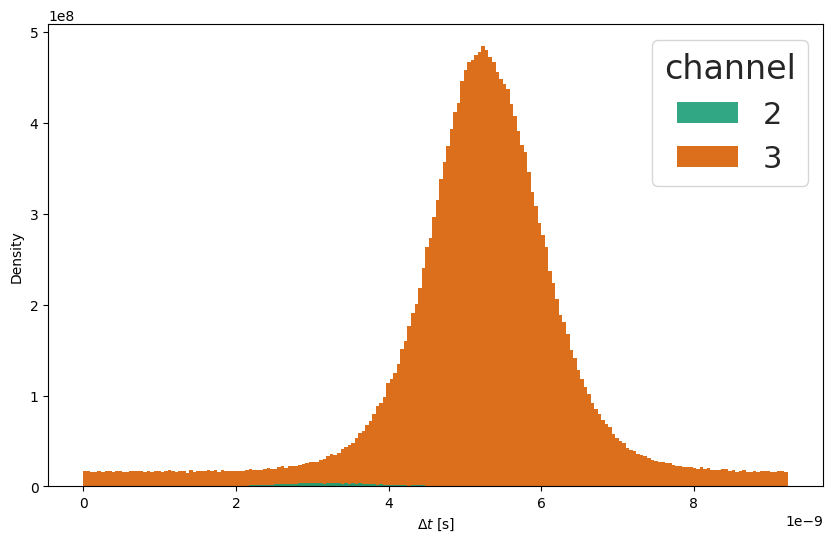

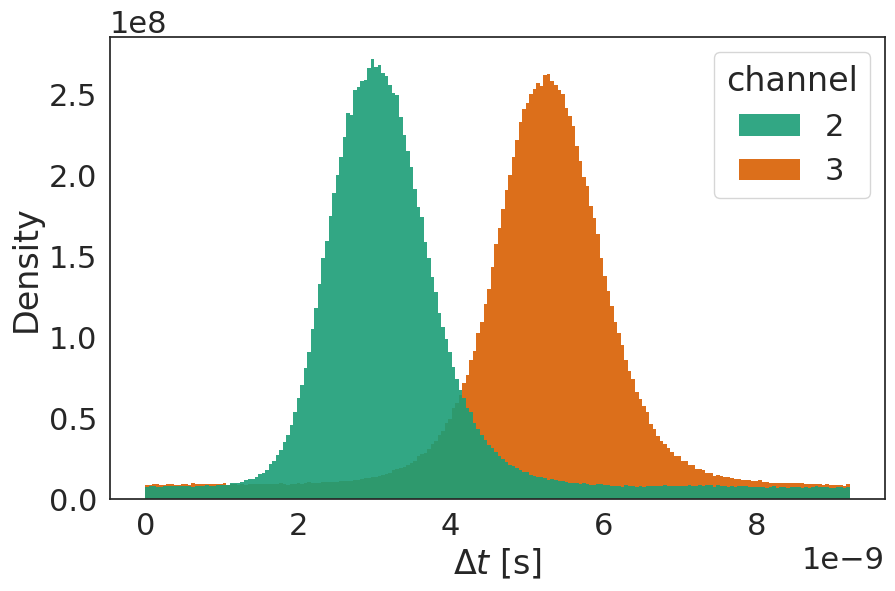

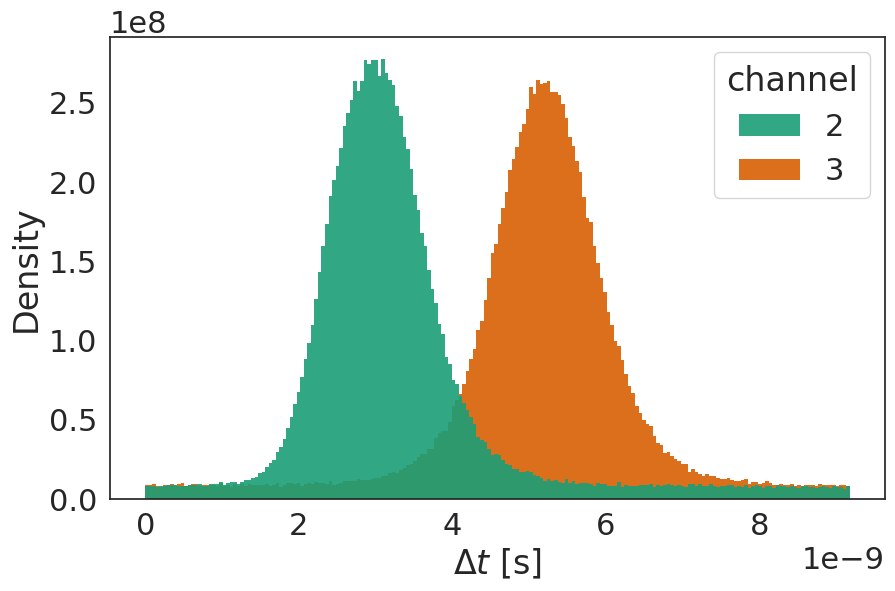

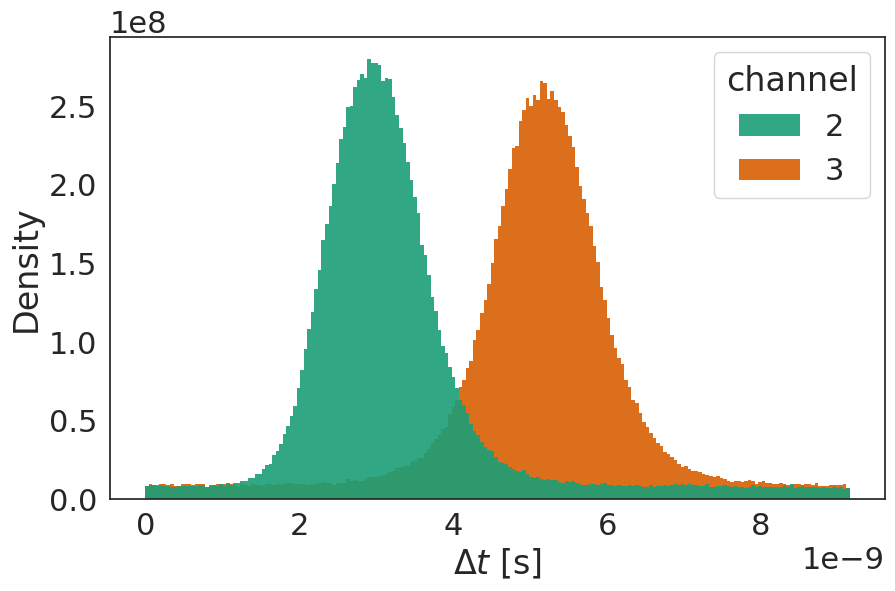

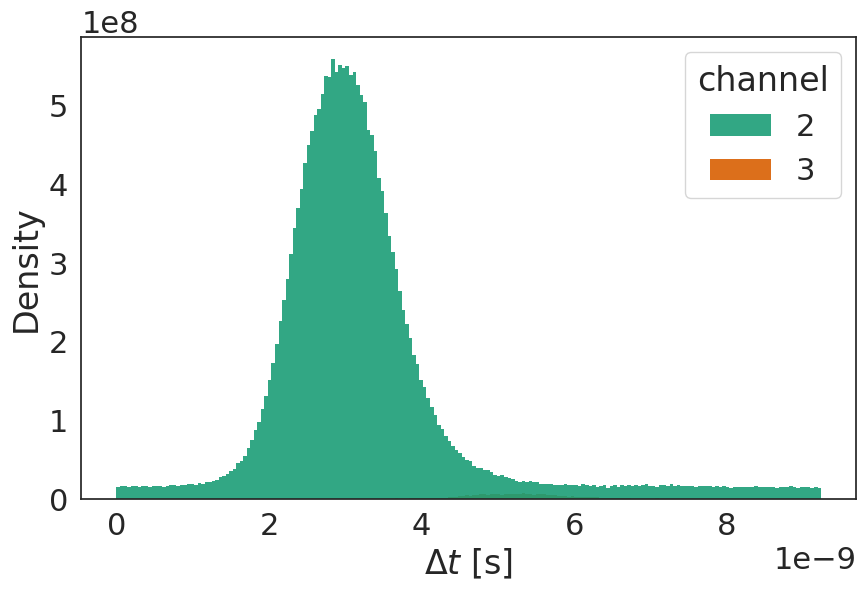

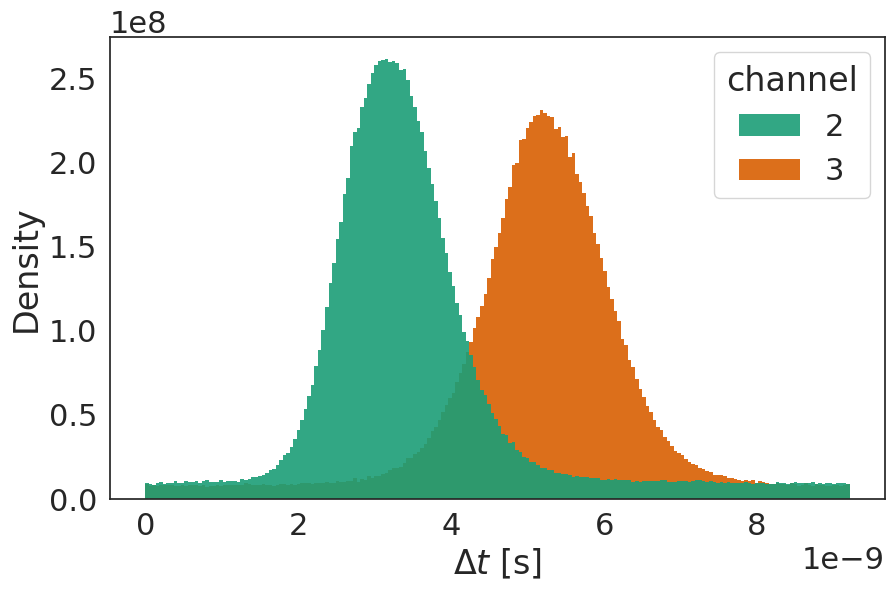

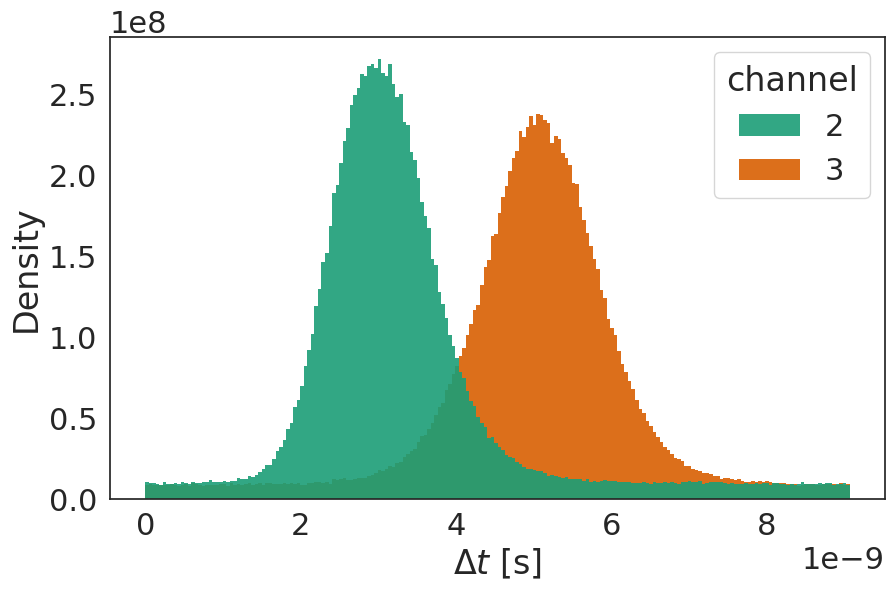

In [ ]:
cleaned_data_to_txt('/content/coincidences/d_da_coincidences.txt', cut=1e-8, window=4e-9)
cleaned_data_to_txt('/content/coincidences/d_hv_coincidences.txt', cut=1e-8, window=4e-9)
cleaned_data_to_txt('/content/coincidences/l_da_coincidences.txt', cut=1e-8, window=4e-9)
cleaned_data_to_txt('/content/coincidences/l_hv_coincidences.txt', cut=1e-8, window=4e-9)
cleaned_data_to_txt('/content/coincidences/l_lr_coincidences.txt', cut=1e-8, window=4e-9)
cleaned_data_to_txt('/content/coincidences/mixed_da_coincidences.txt', cut=1e-8, window=4e-9)
cleaned_data_to_txt('/content/coincidences/mixed_hv_coincidences.txt', cut=1e-8, window=4e-9)

## Probabilities: all cases

In [ ]:
class probability():
  def __init__(self, h, v, d, a, r, l, sigma_h, sigma_v, sigma_d, sigma_a, sigma_r, sigma_l):
        self.h = h
        self.v = v
        self.d = d
        self.a = a
        self.r = r
        self.l = l
        self.sigma_h = sigma_h
        self.sigma_v = sigma_v
        self.sigma_d = sigma_d
        self.sigma_a = sigma_a
        self.sigma_r = sigma_r
        self.sigma_l = sigma_l

def get_probabilities(df):
    """
    From the number of coincidences estimate the probabilities
    for each projector of the measurement basis.
    This function considers only two basis.
    parameters:
        df: dataframe with the number of coincidence events
    return:
        pch_2, pch_3: probabilities of the measurement basis
    """
    pch_2 = len(df[df['channel'] == 2]) / len(df)
    pch_3 = len(df[df['channel'] == 3]) / len(df)
    return pch_2, pch_3

def probabilities(df_HV, df_DA=None, df_RL=None, basis='hv'):
    """
    From the number of coincidence events estimate the probabilities
    for each projector of the measurement basis.
    """
    if basis.lower() == 'hv':
        N = len(df_HV)
        df = df_HV
        nH = len(df[df['channel'] == 2])
        nV = len(df[df['channel'] == 3])
        pH = nH / N
        pV = nV / N
        sigma_H = np.sqrt(nH / (N**2) + (nH**2) / N**3)
        sigma_V = np.sqrt(nV / (N**2) + (nV**2) / N**3)
        p = probability(pH, pV, 0, 0, 0, 0, sigma_H, sigma_V, 0, 0, 0, 0)
        return p
    elif basis.lower() == 'hv_da':
        N_hv = len(df_HV)
        N_da = len(df_DA)
        nH = len(df_HV[df_HV['channel'] == 2])
        nV = len(df_HV[df_HV['channel'] == 3])
        nD = len(df_DA[df_DA['channel'] == 2])
        nA = len(df_DA[df_DA['channel'] == 3])
        pH = nH / N_hv
        pV = nV / N_hv
        pD = nD / N_da
        pA = nA / N_da
        sigma_H = np.sqrt(nH / (N_hv**2) + (nH**2) / N_hv**3)
        sigma_V = np.sqrt(nV / (N_hv**2) + (nV**2) / N_hv**3)
        sigma_D = np.sqrt(nD / (N_da**2) + (nD**2) / N_da**3)
        sigma_A = np.sqrt(nA / (N_da**2) + (nA**2) / N_da**3)
        p = probability(pH, pV, pD, pA, 0, 0, sigma_H, sigma_V, sigma_D, sigma_A, 0, 0)
        return p
    elif basis == 'all':
        N_hv = len(df_HV)
        N_da = len(df_DA)
        N_lr = len(df_RL)
        nH = len(df_HV[df_HV['channel'] == 2])
        nV = len(df_HV[df_HV['channel'] == 3])
        nD = len(df_DA[df_DA['channel'] == 2])
        nA = len(df_DA[df_DA['channel'] == 3])
        nR = len(df_RL[df_RL['channel'] == 2])
        nL = len(df_RL[df_RL['channel'] == 3])
        pH = nH / N_hv
        pV = nV / N_hv
        pD = nD / N_da
        pA = nA / N_da
        pR = nR / N_lr
        pL = nL / N_lr
        sigma_H = np.sqrt(nH / (N_hv**2) + (nH**2) / N_hv**3)
        sigma_V = np.sqrt(nV / (N_hv**2) + (nV**2) / N_hv**3)
        sigma_D = np.sqrt(nD / (N_da**2) + (nD**2) / N_da**3)
        sigma_A = np.sqrt(nA / (N_da**2) + (nA**2) / N_da**3)
        sigma_R = np.sqrt(nR / (N_lr**2) + (nR**2) / N_lr**3)
        sigma_L = np.sqrt(nL / (N_lr**2) + (nL**2) / N_lr**3)
        p = probability(pH, pV, pD, pA, pR, pL, sigma_H, sigma_V, sigma_D, sigma_A, sigma_R, sigma_L)
        return p
    else: raise ValueError('Basis should be hv or hv_da!')

## Trusted QRNG

In [ ]:
def trusted_randomness(pch_2, sigma_pch_2, pch_3, sigma_pch_3):
    """
    From the probabilities of the measurement basis, estimate the guessing
    probability of the randomness of the measurement and the min entropy.
    parameters:
        pch_2, pch_3: probabilities of the measurement basis
    return:
        guess_p: guessing probability
        error_p: error of the guessing probability
        h_min: min entropy
        h_error: error of the min entropy
    """
    guess_p = max(pch_3, pch_2)
    if guess_p == pch_2:
      error_p = sigma_pch_2
    else:
      error_p = sigma_pch_3
    h_min = -np.log2(guess_p)
    h_error = error_p / (guess_p * np.log(2))
    return guess_p, error_p, h_min, h_error

In [ ]:
# For the trusted QRNG setup, use the first set of data to estimate the classical min-entropy for the mixed state and for the pure D state
mixed_hv_file = '/content/cleaned_data/mixed_hv_coincidences_clean.txt'
d_hv_file = '/content/cleaned_data/d_hv_coincidences_clean.txt'
files = [mixed_hv_file, d_hv_file]
if os.path.isdir('/content/results') == False:
  os.mkdir('/content/results')
for f in files:
  filename = '/content/results/' + f[22:45] + '_results_trusted.txt'
  out = open(filename, 'w')
  df = pd.read_csv(f, usecols=['time', 'channel'], dtype={'time': np.float128, 'channel': np.int64})
  p = probabilities(df)
  pch_2 = p.h
  sigma_2 = p.sigma_h
  pch_3 = p.v
  sigma_3 = p.sigma_v
  guess_p, error_p, h_min, h_error = trusted_randomness(pch_2, sigma_2, pch_3, sigma_3)
  print(f[22:45])
  print('pch_2:', pch_2, 'pch_3:', pch_3)
  print('guess_p:', guess_p, 'h_min:', h_min)
  print('error_guess_p:', error_p, 'error_h_min:', h_error, '\n')
  out.write('pH: {}\n'.format(pch_2))
  out.write('sigma_H: {}\n'.format(sigma_2))
  out.write('pV: {}\n'.format(pch_3))
  out.write('sigma_V: {}\n'.format(sigma_3))
  out.write('guess_p: {}\n'.format(guess_p))
  out.write('sigma_guess_p: {}\n'.format(error_p))
  out.write('h_min: {}\n'.format(h_min))
  out.write('sigma_h_min: {}\n'.format(h_error))
  out.close()

mixed_hv_coincidences_c
pch_2: 0.5035350422693377 pch_3: 0.49646495773066235
guess_p: 0.5035350422693377 h_min: 0.9898359123871422
error_guess_p: 0.0007929907527732281 error_h_min: 0.0022720242494757704 

d_hv_coincidences_clean
pch_2: 0.4830342097787146 pch_3: 0.5169657902212854
guess_p: 0.5169657902212854 h_min: 0.9518592803259811
error_guess_p: 0.0005960899838742369 error_h_min: 0.0016635067153879448 



## Source-DI QRNG: entropic uncertainty principle

In [ ]:
def entropic_uncertainty_principle_randomness(pch_2, sigma_pch_2, pch_3, sigma_pch_3):
    """
    From the probabilities of the measurement basis, estimates bounds for
    the guessing probability and the min entropy applying the entropic uncertainty priciple.
    pch_2 and pch_3 are probability of measurements on the ausiliary basis,
    the results of projective measurements in POVM Z. The bound obtained
    is on the variable corresponding to the POVM X.
    parameters:
        pch_2, pch_3: probabilities of the measurement basis
    return:
        guess_p: guessing probability (upper bound)
        error_p: uncertainty of the guessing probability
        h_min: min entropy (lower bound)
        h_error: uncertainty of the min entropy
    """
    dim = 2
    h_min = np.log2(dim) - 2 * np.log2(sum([np.sqrt(pch_2), np.sqrt(pch_3)]))
    h_error = (1 / np.log(2)) * (1 / (np.sqrt(pch_2) + np.sqrt(pch_3))) * np.sqrt(pch_2**(-1) * sigma_pch_2**2 + pch_3**(-1) * sigma_pch_3**2)
    guess_p = 2**(-h_min)
    error_p = h_error * 2**(-h_min) / np.log(2)
    return guess_p, error_p, h_min, h_error

In [ ]:
# For the Source-Device-Independent QRNG, use the first and the second set of data to calculate the quantum conditional min-entropy
# using the entropic uncertainty principle, for both the mixed state and the pure D state.
# For the Source-Device-Independent QRNG, use the third set of data to calculate the quantum conditional min-entropy
# using the entropic uncertainty principle, for the L state, using both the Entropic Uncertainty Principle and the tomographic method.
mixed_da = '/content/cleaned_data/mixed_da_coincidences_clean.txt'
d_da = '/content/cleaned_data/d_da_coincidences_clean.txt'
l_da = '/content/cleaned_data/l_da_coincidences_clean.txt'
l_hv = '/content/cleaned_data/l_hv_coincidences_clean.txt'
l_lr = '/content/cleaned_data/l_lr_coincidences_clean.txt'
files = [mixed_da, d_da, l_da, l_hv, l_lr]
for f in files:
  filename = '/content/results/' + f[22:45] + '_results_sdi_eup.txt'
  out = open(filename, 'w')
  df = pd.read_csv(f, usecols=['time', 'channel'], dtype={'time': np.float128, 'channel': np.int64})
  p = probabilities(df)
  pch_2 = p.h
  sigma_2 = p.sigma_h
  pch_3 = p.v
  sigma_3 = p.sigma_v
  guess_p, error_p, h_min, h_error = entropic_uncertainty_principle_randomness(pch_2, sigma_2, pch_3, sigma_3)
  print(f[22:45])
  print('pch_2:', pch_2, 'pch_3:', pch_3)
  print('guess_p:', guess_p, 'h_min:', h_min)
  print('error_guess_p:', error_p, 'error_h_min:', h_error, '\n')
  out.write('pH: {}\n'.format(pch_2))
  out.write('sigma_H: {}\n'.format(sigma_2))
  out.write('pV: {}\n'.format(pch_3))
  out.write('sigma_V: {}\n'.format(sigma_3))
  out.write('guess_p: {}\n'.format(guess_p))
  out.write('sigma_guess_p: {}\n'.format(error_p))
  out.write('h_min: {}\n'.format(h_min))
  out.write('sigma_h_min: {}\n'.format(h_error))
  out.close()

mixed_da_coincidences_c
pch_2: 0.5094401597221658 pch_3: 0.4905598402778342
guess_p: 0.9999108754412328 h_min: 0.00012858528909354128
error_guess_p: 0.0020977281954239445 error_h_min: 0.001454163985962833 

d_da_coincidences_clean
pch_2: 0.00865811260870927 pch_3: 0.9913418873912907
guess_p: 0.5926452896523302 h_min: 0.754759214352318
error_guess_p: 0.0020051548092922884 error_h_min: 0.002345192692685564 

l_da_coincidences_clean
pch_2: 0.49401476637727215 pch_3: 0.5059852336227278
guess_p: 0.9999641756951005 h_min: 5.1684472807345117e-05
error_guess_p: 0.0035227188684058487 error_h_min: 0.0024418501291243793 

l_hv_coincidences_clean
pch_2: 0.4928929310988461 pch_3: 0.5071070689011539
guess_p: 0.9999494870200734 h_min: 7.287666626498712e-05
error_guess_p: 0.00329810576538046 error_h_min: 0.0022861881946403505 

l_lr_coincidences_clean
pch_2: 0.9872640676786124 pch_3: 0.012735932321387623
guess_p: 0.612132637306418 h_min: 0.7080838039772386
error_guess_p: 0.002561675981611599 error_h_m

## Source-DI QRNG: full tomography

In [ ]:
def density_matrix(pH, pV, pD=0, pA=0, pR=0, pL=0, sigma_H=0, sigma_V=0, sigma_D=0, sigma_A=0, sigma_R=0, sigma_L=0):
    """
    Computes the density matrix from the probabilities of the measurement basis.
    parameters:
        pH, pV, pD, pA, pR, pL: probabilities of the measurement basis
        sigma_H, sigma_V, sigma_D, sigma_A, sigma_R, sigma_L: error over probabilities
    return:
        rho: density matrix
        S: Stokes coefficients as in D. F. V. James et al., Phys. Rev. A 64, 052312 (2001)
        sigma_S: error over the Stokes coefficients
    """
    S_0 = pH + pV
    S_1 = pA - pD
    S_2 = pR - pL
    S_3 = pH - pV
    err_0 = np.sqrt(sigma_H**2 + sigma_V**2)
    err_1 = np.sqrt(sigma_D**2 + sigma_A**2)
    err_2 = np.sqrt(sigma_R**2 + sigma_L**2)
    err_3 = np.sqrt(sigma_H**2 + sigma_V**2)
    S = np.array([S_0, S_1, S_2, S_3]) / S_0
    sigma_S = [err_0, err_1, err_2, err_3]
    print('Stokes coefficients: '+str(S))
    print('Check normalization: '+str(np.linalg.norm(S[1:])))
    sigma_0 = np.identity(2)
    sigma_1 = np.array([[0, 1], [1, 0]])
    sigma_2 = np.array([[0, -1j], [1j, 0]])
    sigma_3 = np.array([[1, 0],[0, -1]])
    sigma = [sigma_0, sigma_1, sigma_2, sigma_3]
    rho = 0.5 * (sigma[0] * S[0] + sigma[1] * S[1] + sigma[2] * S[2] + sigma[3] * S[3])
    return rho, S, sigma_S

def tomographic_randomness(S, sigma_S):
    """
    From the probabilities of the measurement basis, estimates bounds for
    the guessing probability and the min entropy applying Fiorentino's method
    parameters:
        S: Stokes coefficients as in D. F. V. James et al., Phys. Rev. A 64, 052312 (2001)
        sigma_S: error over Stokes coefficients
    return:
        guess_p: guessing probability (upper bound)
        error_p: error over guessing probability
        h_min: min entropy (lower bound)
        h_error: error over min entropy
    """
    guess_p = (1 + np.sqrt(1 - S[1]**2 - S[2]**2)) / 2
    error_p = 0.5 * (1 - S[1]**2 - S[2]**2)**(-1/2) * np.sqrt((sigma_S[1] * S[1])**2 + (sigma_S[2] * S[2])**2)
    h_min = -np.log2(guess_p)
    h_error = error_p / (guess_p * np.log(2))
    return guess_p, error_p, h_min, h_error

In [ ]:
# For the Source-Device-Independent QRNG, use the first and the second set of data
# to calculate the quantum conditional min-entropy using the tomographic method, for both the mixed state and the pure D state.
# (since we don’t have full tomographic measurements we can assume S_{2} = 0)
# For the Source-Device-Independent QRNG, use the third set of data to calculate
# the quantum conditional min-entropy using the entropic uncertainty principle, for the L state,
# using both the Entropic Uncertainty Principle and the tomographic method.
mixed_hv = '/content/cleaned_data/mixed_hv_coincidences_clean.txt'
mixed_da = '/content/cleaned_data/mixed_da_coincidences_clean.txt'
d_hv = '/content/cleaned_data/d_hv_coincidences_clean.txt'
d_da = '/content/cleaned_data/d_da_coincidences_clean.txt'
l_da = '/content/cleaned_data/l_da_coincidences_clean.txt'
l_hv = '/content/cleaned_data/l_hv_coincidences_clean.txt'
l_lr = '/content/cleaned_data/l_lr_coincidences_clean.txt'
mixed = [mixed_hv, mixed_da]
d =[d_hv, d_da]
l = [l_hv, l_da, l_lr]
sim = [mixed, d, l]
name = ['mixed', 'd', 'l']
for s, n in zip(sim, name):
  dfs = []
  for f in s:
    print(f[22:45])
    dfs.append(pd.read_csv(f, usecols=['time', 'channel'], dtype={'time': np.float128, 'channel': np.int64}))
  if s != l:
    p = probabilities(*dfs, basis='hv_da')
  else:
    p = probabilities(*dfs, basis='all')
  print('pH: '+str(p.h))
  print('pV: '+str(p.v))
  print('pA: '+str(p.a))
  print('pD: '+str(p.d))
  print('pR: '+str(p.r))
  print('pL: '+str(p.l))
  rho, s, sigma_s = density_matrix(p.h, p.v, p.a, p.d, p.r, p.l, p.sigma_h, p.sigma_v, p.sigma_a, p.sigma_d, p.sigma_r, p.sigma_l)
  guess_p, error_p, h_min, h_error = tomographic_randomness(s, sigma_s)
  print('guess_p:', guess_p, 'h_min:', h_min)
  print('error_guess_p:', error_p, 'error_h_min:', h_error, '\n')
  filename = '/content/results/' + f[22:45] + '_results_sdi_tomography.txt'
  out = open(filename, 'w')
  out.write('pH: {}\n'.format(pch_2))
  out.write('sigma_H: {}\n'.format(sigma_2))
  out.write('pV: {}\n'.format(pch_3))
  out.write('sigma_V: {}\n'.format(sigma_3))
  out.write('guess_p: {}\n'.format(guess_p))
  out.write('sigma_guess_p: {}\n'.format(error_p))
  out.write('h_min: {}\n'.format(h_min))
  out.write('sigma_h_min: {}\n'.format(h_error))
  filename = '/content/results/' + n + '_density_matrix.txt'
  np.savetxt(filename, rho.reshape(2, 2))

mixed_hv_coincidences_c
mixed_da_coincidences_c
pH: 0.5035350422693377
pV: 0.49646495773066235
pA: 0.4905598402778342
pD: 0.5094401597221658
pR: 0
pL: 0
Stokes coefficients: [1.         0.01888032 0.         0.00707008]
Check normalization: 0.02016066858276336
guess_p: 0.999910875441233 h_min: 0.00012858528909322483
error_guess_p: 9.517043490374832e-06 error_h_min: 1.3731415253814103e-05 

d_hv_coincidences_clean
d_da_coincidences_clean
pH: 0.4830342097787146
pV: 0.5169657902212854
pA: 0.9913418873912907
pD: 0.00865811260870927
pR: 0
pL: 0
Stokes coefficients: [ 1.         -0.98268377  0.         -0.03393158]
Check normalization: 0.9832694205416305
guess_p: 0.5926452896523304 h_min: 0.7547592143523174
error_guess_p: 0.0038153060285135375 error_h_min: 0.009287719286589292 

l_hv_coincidences_clean
l_da_coincidences_clean
l_lr_coincidences_clean
pH: 0.4928929310988461
pV: 0.5071070689011539
pA: 0.5059852336227278
pD: 0.49401476637727215
pR: 0.9872640676786124
pL: 0.012735932321387623
Sto

In [ ]:
def plot_density_matrix(file_path, save_path='/content/results/mixed_density_matrix_plot.jpg'):
    """
    Plots the real and imaginary parts of a density matrix represented by the data in the given text file.
    parameters:
      file_path: path to the text file containing the data
      save_path: path to save the resulting 3D plot as a PDF
    return:
      None
    """
    # Load data from the text file
    data = np.loadtxt(file_path, dtype=np.complex128)
    # Convert the data to a numpy array
    density_matrix = np.array(data)
    # Extract real and imaginary parts
    real_part = np.real(density_matrix)
    imag_part = np.imag(density_matrix)
    # Create figure and 3D axis for the real part
    fig = plt.figure(figsize=(10, 6))
    ax_real = fig.add_subplot(121, projection='3d')
    ax_real.set_title(r'Re[$\rho$]', fontsize=16)
    ax_real.tick_params(axis='both', which='major', labelsize=10)
    # Set the bar positions and dimensions
    side_length = real_part.shape[0]
    xpos, ypos = np.meshgrid(np.arange(side_length), np.arange(side_length))
    zpos = np.zeros_like(xpos)
    # Set the bar heights based on the real_part values
    dx = dy = 1
    for x, y, z, val in zip(xpos.flatten(), ypos.flatten(), zpos.flatten(), real_part.flatten()):
        ax_real.bar3d(x, y, z, dx, dy, val, color='darkturquoise', zsort='average')
    # Create 3D axis for the imaginary part
    ax_imag = fig.add_subplot(122, projection='3d')
    ax_imag.set_title(r'Im[$\rho$]', fontsize=16)
    ax_imag.tick_params(axis='both', which='major', labelsize=10)
    # Set the bar heights based on the imag_part values
    dz_imag = imag_part.flatten()
    # Use a different color for positive and negative values
    colors = ['darkturquoise' if val >= 0 else 'paleturquoise' for val in dz_imag]
    for x, y, z, val, color in zip(xpos.flatten(), ypos.flatten(), zpos.flatten(), dz_imag, colors):
        ax_imag.bar3d(x, y, z, dx, dy, val, color=color, zsort='average')
    # Save the plot as a PDF
    plt.savefig(save_path)
    # Show the plot
    plt.show()

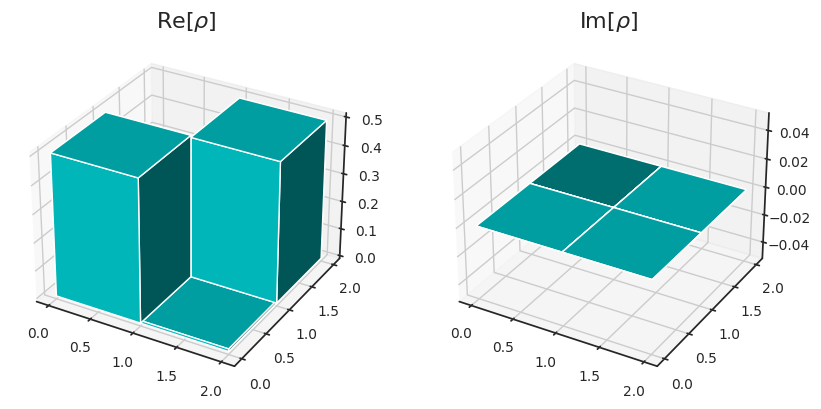

In [ ]:
# Plot and save the density matrix
plot_density_matrix('/content/results/mixed_density_matrix.txt')

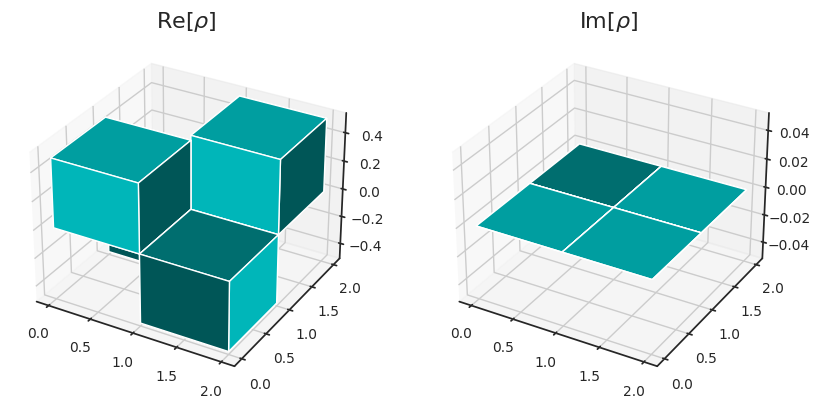

In [ ]:
# Plot and save the density matrix
plot_density_matrix('/content/results/d_density_matrix.txt', save_path='/content/results/d_density_matrix_plot.jpg')

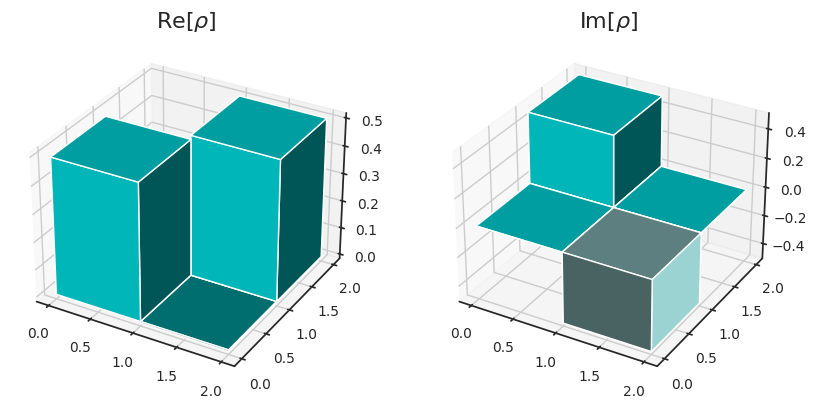

In [ ]:
# Plot and save the density matrix
plot_density_matrix('/content/results/l_density_matrix.txt', save_path='/content/results/l_density_matrix_plot.jpg')

## LHL security parameter estimate

In [ ]:
def security_parameter(H, error_H, length):
    epsilon = 2**(length/2. - 1 - H/2.)
    e_epsilon = 2**(length/2. - 2 - H/2.) * error_H * np.log(2)
    return epsilon, e_epsilon

def security(H_min, H_err, length, path, path_err):
    """
    Using the min-entropies estimated in the previous steps, let's consider how the security parameter from
    the Leftover Hashing Lemma (LHL) changes as a function of the block length.
    Given a delta-universal hashing family: if there is not quantum side information as in the case of trusted QRNGs the
    trace distance is upper bounded by: 1/2 sqrt{Z | (delta + P_g(x) - 1)}
    If there is quantum side information as in the case of SDI-QRNGs the
    trace distance is upper bounded by: 1/2 sqrt{Z | P_{coll}(x|E)}
    """
    if os.path.isdir('/content/security') == False:
      os.mkdir('/content/security')
    columns = [str(h) for h in H_min]
    security = pd.DataFrame(columns=columns)
    e_security = pd.DataFrame(columns=columns)
    for h, e in zip (H_min, H_err):
        eps = []
        e_eps = []
        for l in length:
            epsilon, e_epsilon = security_parameter(h, e, l)
            print('h: {}, l: {}, epsilon: {}, e_epsilon: {}'.format(h, l, epsilon, e_epsilon))
            eps.append(epsilon)
            e_eps.append(e_epsilon)
        security[str(h)] = eps
        e_security[str(h)] = e_eps
    security['length'] = length
    e_security['length'] = length
    security.to_csv(path)
    e_security.to_csv(path_err)

In [ ]:
length = np.arange(1, 20, 1)

# Trusted
path_trusted = '/content/security/security_trusted.csv'
path_err_trusted = '/content/security/security_err_trusted.csv'
H_min = [0.990, 0.952]
H_err = [0.002, 0.002]
security(H_min, H_err, length, path_trusted, path_err_trusted)

# SDI - Entropic Uncertainty Principle
path_sdi_eup = '/content/security/security_sdi_eup.csv'
path_err_sdi_eup = '/content/security/security_err_sdi_eup.csv'
H_min = [8e-06, 0.708, 0.755]
H_err = [1e-06, 0.003, 0.002]
security(H_min, H_err, length, path_sdi_eup, path_err_sdi_eup)

# SDI - Tomography
path_sdi_tomography = '/content/security/security_sdi_tomography.csv'
path_err_sdi_tomography = '/content/security/security_err_sdi_tomography.csv'
H_min = [4e-06, 0.708, 0.755]
H_err = [2e-06, 0.001, 0.001]
security(H_min, H_err, length, path_sdi_tomography, path_err_sdi_tomography)

h: 0.99, l: 1, epsilon: 0.5017358742547514, e_epsilon: 0.0003477768066254601
h: 0.99, l: 2, epsilon: 0.7095616781001912, e_epsilon: 0.0004918306766085311
h: 0.99, l: 3, epsilon: 1.0034717485095028, e_epsilon: 0.0006955536132509203
h: 0.99, l: 4, epsilon: 1.4191233562003824, e_epsilon: 0.0009836613532170622
h: 0.99, l: 5, epsilon: 2.006943497019005, e_epsilon: 0.0013911072265018407
h: 0.99, l: 6, epsilon: 2.838246712400765, e_epsilon: 0.0019673227064341244
h: 0.99, l: 7, epsilon: 4.01388699403801, e_epsilon: 0.002782214453003681
h: 0.99, l: 8, epsilon: 5.67649342480153, e_epsilon: 0.003934645412868249
h: 0.99, l: 9, epsilon: 8.02777398807602, e_epsilon: 0.005564428906007362
h: 0.99, l: 10, epsilon: 11.35298684960306, e_epsilon: 0.007869290825736498
h: 0.99, l: 11, epsilon: 16.05554797615204, e_epsilon: 0.011128857812014724
h: 0.99, l: 12, epsilon: 22.70597369920612, e_epsilon: 0.015738581651472995
h: 0.99, l: 13, epsilon: 32.11109595230408, e_epsilon: 0.022257715624029447
h: 0.99, l: 14

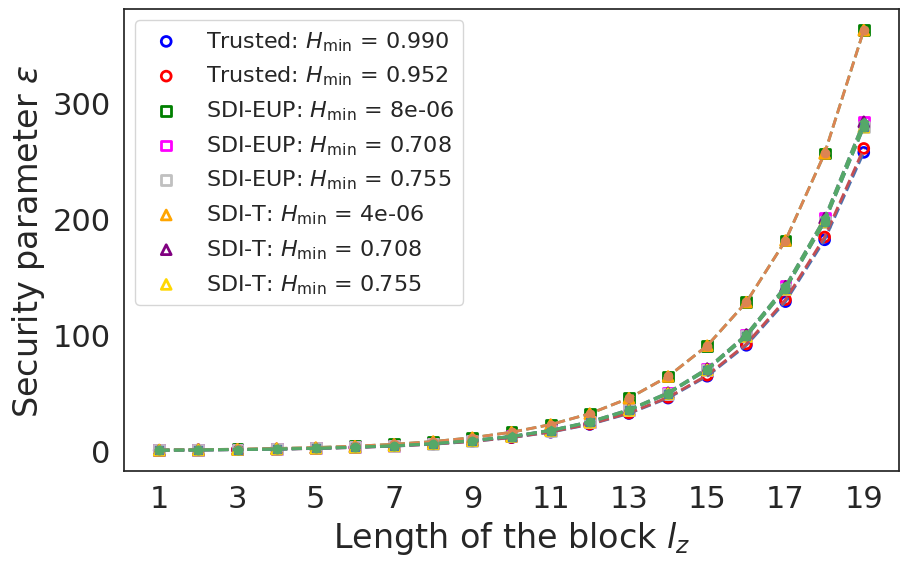

In [ ]:
# Read data from each CSV file
trusted_data = pd.read_csv(path_trusted)
sdi_eup_data = pd.read_csv(path_sdi_eup)
sdi_tomography_data = pd.read_csv(path_sdi_tomography)
# Plot the data
plt.figure(figsize=(10, 6))
# Scatter plot for each file with bold points
plt.scatter(trusted_data['length'], trusted_data['0.99'], label='Trusted: $H_{\min}$ = 0.990', s=50, marker='o', facecolors='none', edgecolors='blue', linewidth=2)
plt.scatter(trusted_data['length'], trusted_data['0.952'], label='Trusted: $H_{\min}$ = 0.952', s=50, marker='o', facecolors='none', edgecolors='red', linewidth=2)
plt.scatter(sdi_eup_data['length'], sdi_eup_data['8e-06'], label='SDI-EUP: $H_{\min}$ = 8e-06', s=50, marker='s', facecolors='none', edgecolors='green', linewidth=2)
plt.scatter(sdi_eup_data['length'], sdi_eup_data['0.708'], label='SDI-EUP: $H_{\min}$ = 0.708', s=50, marker='s', facecolors='none', edgecolors='magenta', linewidth=2)
plt.scatter(sdi_eup_data['length'], sdi_eup_data['0.755'], label='SDI-EUP: $H_{\min}$ = 0.755', s=50, marker='s', facecolors='none', edgecolors='silver', linewidth=2)
plt.scatter(sdi_tomography_data['length'], sdi_tomography_data['4e-06'], label='SDI-T: $H_{\min}$ = 4e-06', s=50, marker='^', facecolors='none', edgecolors='orange', linewidth=2)
plt.scatter(sdi_tomography_data['length'], sdi_tomography_data['0.708'], label='SDI-T: $H_{\min}$ = 0.708', s=50, marker='^', facecolors='none', edgecolors='purple', linewidth=2)
plt.scatter(sdi_tomography_data['length'], sdi_tomography_data['0.755'], label='SDI-T: $H_{\min}$ = 0.755', s=50, marker='^', facecolors='none', edgecolors='gold', linewidth=2)
# Line plot connecting the points with dashed lines
plt.plot(trusted_data['length'], trusted_data['0.99'], 'b--', linewidth=2)
plt.plot(trusted_data['length'], trusted_data['0.952'], 'r--', linewidth=2)
plt.plot(sdi_eup_data['length'], sdi_eup_data['8e-06'], 'g--', linewidth=2)
plt.plot(sdi_eup_data['length'], sdi_eup_data['0.708'], 'm--', linewidth=2)
plt.plot(sdi_eup_data['length'], sdi_eup_data['0.755'], 's--', linewidth=2)
plt.plot(sdi_tomography_data['length'], sdi_tomography_data['4e-06'], 'o--', linewidth=2)
plt.plot(sdi_tomography_data['length'], sdi_tomography_data['0.708'], 'p--', linewidth=2)
plt.plot(sdi_tomography_data['length'], sdi_tomography_data['0.755'], 'go--', linewidth=2)
# Set x-axis ticks to selected integer values
selected_ticks_trusted = [int(x) for x in trusted_data['length'].unique()[::2]]
plt.xticks(selected_ticks_trusted)
selected_ticks_sdi_eup = [int(x) for x in sdi_eup_data['length'].unique()[::2]]
plt.xticks(selected_ticks_sdi_eup)
selected_ticks_sdi_tomography = [int(x) for x in sdi_tomography_data['length'].unique()[::2]]
plt.xticks(selected_ticks_sdi_tomography)
plt.xlabel('Length of the block $l_{z}$')
plt.ylabel('Security parameter $\epsilon$')
plt.legend(fontsize=16)
plt.savefig('/content/security/security_estimate_plot.jpg', bbox_inches='tight')
plt.show()

## Download the results

In [ ]:
# Specify the folder path and zip filename
folder_path = "/content/cleaned_data"
zip_filename = "cleaned_data_results.zip"
# Zip all files inside the folder
!zip -r {zip_filename} {folder_path}/*
# Download the zip file
gc_files.download(zip_filename)

  adding: content/cleaned_data/d_da_coincidences_clean.txt (deflated 66%)
  adding: content/cleaned_data/d_hv_coincidences_clean.txt (deflated 66%)
  adding: content/cleaned_data/l_da_coincidences_clean.txt (deflated 66%)
  adding: content/cleaned_data/l_hv_coincidences_clean.txt (deflated 66%)
  adding: content/cleaned_data/l_lr_coincidences_clean.txt (deflated 67%)
  adding: content/cleaned_data/mixed_da_coincidences_clean.txt (deflated 66%)
  adding: content/cleaned_data/mixed_hv_coincidences_clean.txt (deflated 66%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Specify the folder path and zip filename
folder_path = "/content/security"
zip_filename = "security_results.zip"
# Zip all files inside the folder
!zip -r {zip_filename} {folder_path}/*
# Download the zip file
gc_files.download(zip_filename)

  adding: content/security/security_err_sdi_eup.csv (deflated 50%)
  adding: content/security/security_err_sdi_tomography.csv (deflated 51%)
  adding: content/security/security_err_trusted.csv (deflated 51%)
  adding: content/security/security_estimate_plot.jpg (deflated 20%)
  adding: content/security/security_sdi_eup.csv (deflated 47%)
  adding: content/security/security_sdi_tomography.csv (deflated 47%)
  adding: content/security/security_trusted.csv (deflated 47%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Specify the folder path and zip filename
folder_path = "/content/results"
zip_filename = "final_results.zip"
# Zip all files inside the folder
!zip -r {zip_filename} {folder_path}/*
# Download the zip file
gc_files.download(zip_filename)

  adding: content/results/d_da_coincidences_clean_results_sdi_eup.txt (deflated 37%)
  adding: content/results/d_da_coincidences_clean_results_sdi_tomography.txt (deflated 39%)
  adding: content/results/d_density_matrix_plot.jpg (deflated 17%)
  adding: content/results/d_density_matrix.txt (deflated 63%)
  adding: content/results/d_hv_coincidences_clean_results_trusted.txt (deflated 46%)
  adding: content/results/l_da_coincidences_clean_results_sdi_eup.txt (deflated 37%)
  adding: content/results/l_density_matrix_plot.jpg (deflated 18%)
  adding: content/results/l_density_matrix.txt (deflated 54%)
  adding: content/results/l_hv_coincidences_clean_results_sdi_eup.txt (deflated 38%)
  adding: content/results/l_lr_coincidences_clean_results_sdi_eup.txt (deflated 39%)
  adding: content/results/l_lr_coincidences_clean_results_sdi_tomography.txt (stored 0%)
  adding: content/results/mixed_da_coincidences_c_results_sdi_eup.txt (deflated 40%)
  adding: content/results/mixed_da_coincidences_c_r

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>